# Simple Stochastic Gradient Descent in Two Nodes with TensorFlow, Horovod and IPCMagic.

Here we visualize the minimization of the loss with the SGD algorithm.
For this, we consider a linear model with only two weights (the slope and the offset).

With this example we show how use IPCMagic to run TensorFlow in two nodes from a Jupyter notebook.
We consider blocking and non-blocking execution of code on the IPCluster.
We also show how to combine non-blocking execution and the function `ipcmagic.utilities.watch_asyncresult` to have real time loging during training.

In [1]:
import ipcmagic
import ipyparallel as ipp
from ipcmagic import utilities   

In [2]:
%ipcluster --version

1.0.0


In [3]:
%ipcluster start -n 2 --mpi

IPCluster is ready! (10 seconds)


In [4]:
%%px
import socket
socket.gethostname()

Out[0:1]: 'nid02307'

Out[1:1]: 'nid02306'

In [5]:
%%px
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import horovod.tensorflow.keras as hvd

In [6]:
%%px
hvd.init()

In [7]:
%%px --target 0
tf.version.VERSION

Out[0:4]: '2.3.0'

In [8]:
%%px
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

In [9]:
%%px
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(100)
dataset = dataset.repeat(150)

In [10]:
%%px
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,), activation='linear'),
])

opt = tf.keras.optimizers.SGD(lr=0.5)
opt = hvd.DistributedOptimizer(opt)

model.compile(optimizer=opt,
              loss='mse')

In [11]:
%%px
class TrainHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.vars = []
        self.loss = []

    def on_batch_end(self, batch, logs={}):
        self.vars.append([v.numpy() for v in self.model.variables])
        self.loss.append(logs.get('loss'))
        
history = TrainHistory()

In [12]:
%%px
initial_sync = hvd.callbacks.BroadcastGlobalVariablesCallback(0)

In [ ]:
# %%px

# # blocking execution.
# # the output is visible only at the end of the run

# fit = model.fit(dataset, callbacks=[initial_sync, history])

In [13]:
%%px --noblock -o training

# the non-blocking execution (`%%px --noblock`) returns an `AsyncResult` object inmediately.
# the `AsyncResult` object can be accessed from python with the option `-o <variable>`.
# by doing that we can fetch information while the code running.

fit = model.fit(dataset, callbacks=[initial_sync, history])

<AsyncResult: execute>

In [14]:
# watch the output in real time
utilities.watch_asyncresult(training)

[ stdout 0 ]
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0811

[ stdout 1 ]
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0847



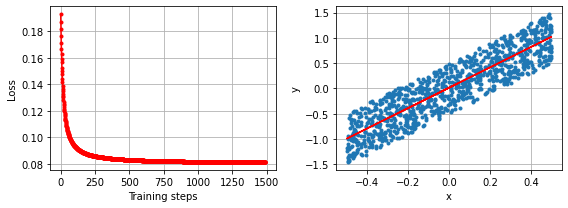

In [15]:
%%px --target 0
slope_hist = np.array(history.vars)[:, 0]
offset_hist = np.array(history.vars)[:, 1]
loss_hist = np.array(history.loss)

matplotlib.rcParams['figure.figsize'] = (8, 3)

plt.subplot(1, 2, 1)
plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_train, y_train, '.')
plt.plot(x_train, slope_hist[-1] * x_train + offset_hist[-1], 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.tight_layout()
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

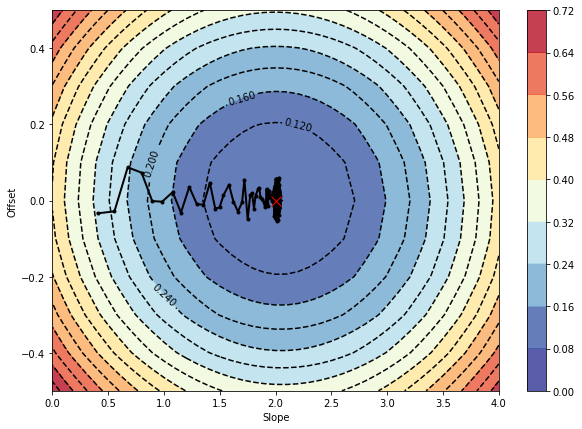

In [16]:
%%px --target 0
def loss_function_field(m, n, xref, yref):
    '''Utility function for ploting the loss'''
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0.0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_train, y_train)

matplotlib.rcParams['figure.figsize'] = (10, 7)

cp = plt.contour(M, N, Z, 15, vmin=Z.min(), vmax=Z.max(), alpha=0.99, colors='k', linestyles='--')
plt.contourf(M, N, Z, vmin=Z.min(), vmax=Z.max(), alpha=0.8, cmap=plt.cm.RdYlBu_r)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=2, c='k')
plt.plot([ref_slope], [ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

In [48]:
%ipcluster stop